# Setup and Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set
import warnings
from pandas.io import gbq
#Custom Python Module with functions specifically for this project
import ChicagoDataCleaningFunctions as cd

# Get the Data

In [8]:
#Read the data in from Google BigQuery
chicago_data = """
                    SELECT unique_key, date, primary_type, location_description, 
                            arrest, domestic, community_area, year
                    FROM `gdac-327115.Chicago.chicago2`
                    WHERE year >= 2011
               """
chicago_data = gbq.read_gbq(chicago_data, project_id="gdac-327115")

In [9]:
#Read in an Excel file with a one to one mapping between Chicago community areas and districts
chicago_districts = pd.read_excel("ChicagoCommunityAreas.xlsx")

In [10]:
#Data type can't be joined on an int
chicago_districts.community_area = chicago_districts["community_area"].astype("string")
chicago_data.community_area = chicago_data["community_area"].astype("string")

In [11]:
#Outer join the two data sets
chicago = chicago_data.merge(chicago_districts, how="outer", left_on="community_area", right_on="community_area", )

In [12]:
#Drop the community area variable since we have a community name variable
chicago.drop("community_area", axis = 1, inplace = True)

# Split the Data in Training and Test Sets

In [13]:
chicago_train = chicago.loc[chicago["year"] != 2021]
chicago_test = chicago.loc[chicago["year"] == 2021]

# Clean the Training Data

In [14]:
#Check for missing values
chicago_train.isnull().sum()

unique_key                 0
date                       0
primary_type               0
location_description    7844
arrest                     0
domestic                   0
year                       0
district_name            218
community_name           218
dtype: int64

In [18]:
%%capture --no-stdout
cd.chicago_data_cleaner(chicago_train, verbose=True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


In [19]:
#Check to make sure the values were cleaned up
chicago_train.isnull().sum()

unique_key              0
date                    0
primary_type            0
location_description    0
arrest                  0
domestic                0
year                    0
district_name           0
community_name          0
Month                   0
Hour                    0
dtype: int64

In [20]:
#Check the dimensions
chicago_train.shape

(2814636, 11)

In [21]:
#Check the first few rows
chicago_train.head()

,unique_key,date,primary_type,location_description,arrest,domestic,year,district_name,community_name,Month,Hour
0,10225218,2015-09-05 23:00:00+00:00,ROBBERY,CTA,False,False,2015,Far Southeast,RIVERDALE,9,23
1,10341077,2015-12-10 05:15:00+00:00,BURGLARY,RESIDENCE,False,False,2015,Far Southeast,RIVERDALE,12,5
2,11861007,2019-10-14 22:47:00+00:00,OTHER OFFENSE,STREET,True,False,2019,Far Southeast,RIVERDALE,10,22
3,10599541,2016-07-15 22:30:00+00:00,INTERFERENCE WITH PUBLIC OFFICER,PARKING,True,False,2016,Far Southeast,RIVERDALE,7,22
4,10707134,2016-10-04 17:00:00+00:00,DECEPTIVE PRACTICE,STREET,False,False,2016,Far Southeast,RIVERDALE,10,17


# Data Visualizations

The purpose of this project is to look at the percentage of crimes that result in an arrest and ultimately predict if an arrest will be made. Therefore, we are only interested in the arrest percentage broken down by each variable.

## Arrest Percentage

In [22]:
#Group by arrest while dividing by the number of rows to get the percentage
arrest_grp = (chicago_train["arrest"].value_counts() / chicago_train.shape[0]) * 100
arrest_grp = pd.DataFrame(arrest_grp).reset_index().rename(columns ={"index": "Arrest", "arrest" : "mean"})
arrest_grp

,Arrest,mean
0,False,76.113217
1,True,23.886783


Text(0.5, 0, 'Arrest Status')

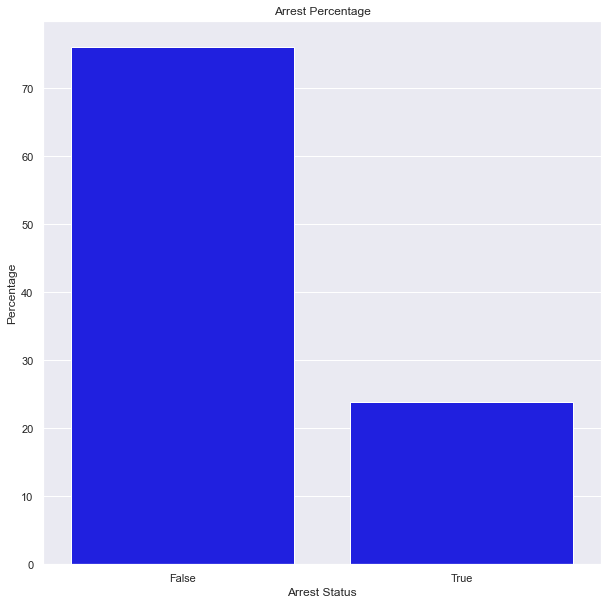

In [23]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Arrest", y = "mean", order = arrest_grp["Arrest"] \
                                            , data = arrest_grp, color = "blue")
plt.title("Arrest Percentage")
plt.ylabel("Percentage")
plt.xlabel("Arrest Status")

Nearly a quarter of every crime results in an arrest. This large class imbalance will play a factor later when we start building models to predict arrest. 

## Primary Type

### Primary Type Ranked By Arrest Percentage

In [28]:
mask = chicago_train["arrest"] == True
crm_by_arrest = chicago_train.loc[mask, "primary_type"].value_counts() / chicago_train[mask].shape[0] * 100
crm_by_arrest = pd.DataFrame(crm_by_arrest).reset_index().rename(columns ={"index": "Crime", "primary_type" : "Percentage"})
crm_by_arrest

,Crime,Percentage
0,NARCOTICS,32.969125
1,BATTERY,16.684912
2,THEFT,9.946365
3,CRIMINAL TRESPASS,6.763386
4,ASSAULT,5.858021
5,OTHER OFFENSE,5.134116
6,WEAPONS VIOLATION,5.056624
7,CRIMINAL DAMAGE,2.831513
8,PUBLIC PEACE VIOLATION,2.334879
9,DECEPTIVE PRACTICE,2.167550


Text(0.5, 0, 'Percentage')

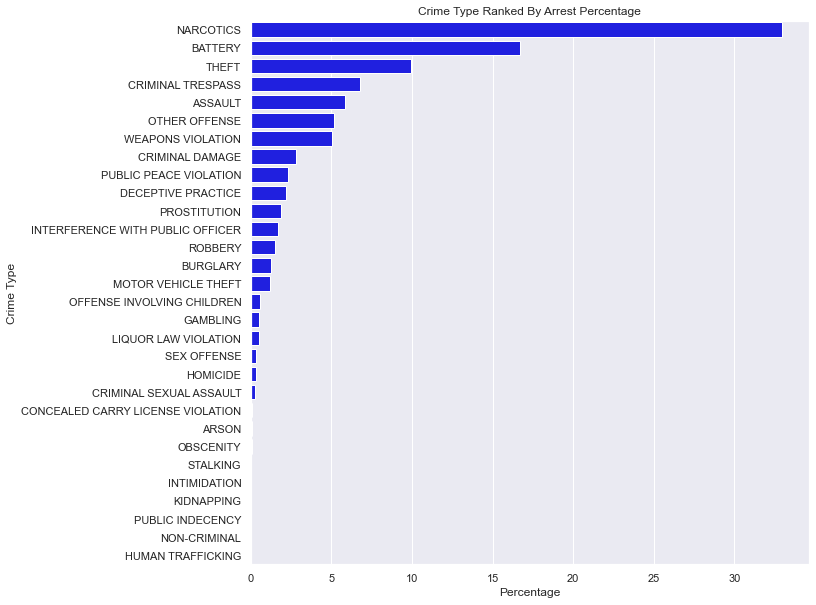

In [29]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Percentage", y = "Crime", order = crm_by_arrest["Crime"] \
                                            , data = crm_by_arrest, color = "blue")
plt.title("Crime Type Ranked By Arrest Percentage")
plt.ylabel("Crime Type")
plt.xlabel("Percentage")

### Arrest Percentage By Primary Type

In [30]:
#Group by primary type while summarizing arrest
crime_grp = chicago_train.groupby("primary_type")["arrest"].aggregate(["mean", "sum"]).sort_values(by="mean", ascending=False)
crime_grp = crime_grp.reset_index()
#Change it to a percentage
crime_grp["mean"] *= 100
crime_grp

,primary_type,mean,sum
0,PUBLIC INDECENCY,100.0,118
1,GAMBLING,99.800399,3500
2,PROSTITUTION,99.670365,12397
3,NARCOTICS,99.646208,221660
4,LIQUOR LAW VIOLATION,98.67919,3362
5,CONCEALED CARRY LICENSE VIOLATION,96.706587,646
6,INTERFERENCE WITH PUBLIC OFFICER,94.768083,11176
7,OBSCENITY,78.294574,404
8,WEAPONS VIOLATION,74.11598,33997
9,PUBLIC PEACE VIOLATION,71.916804,15698


Text(0.5, 0, 'Percentage')

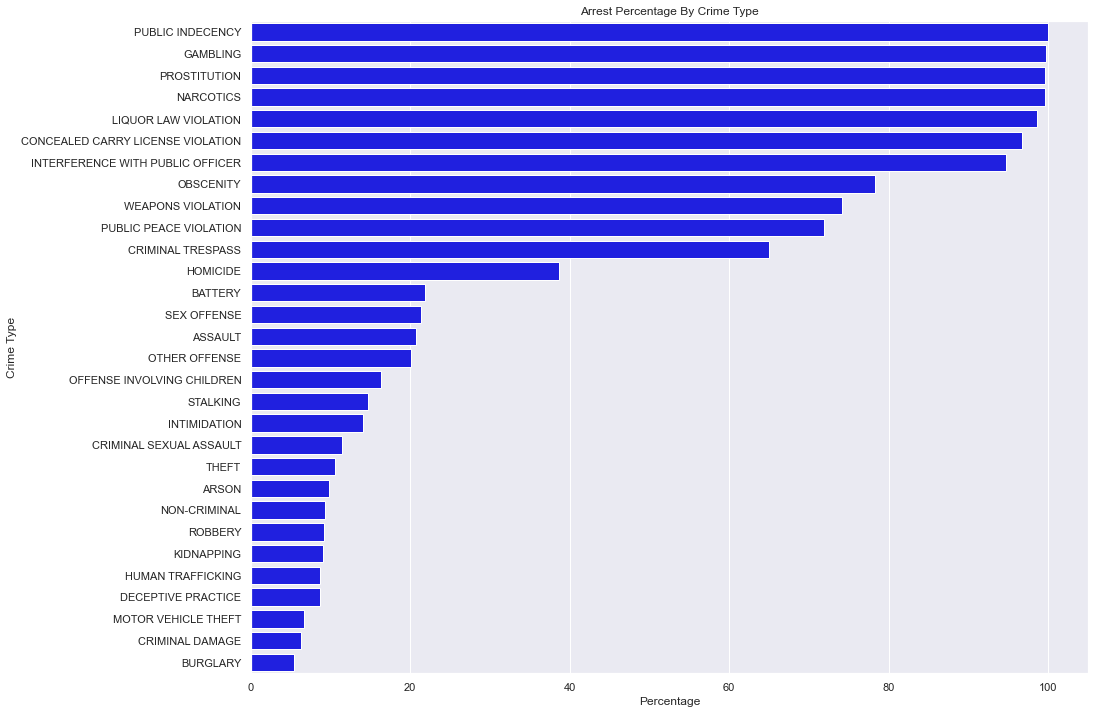

In [31]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,12)})
sns.barplot(x="mean", y = "primary_type", order = crime_grp["primary_type"], data = crime_grp, color = "blue")
plt.title("Arrest Percentage By Crime Type")
plt.ylabel("Crime Type")
plt.xlabel("Percentage")

Interestingly, Narcotic crimes rank 4th of most occurrences and are also 4th in arrest percentage with 99.65%.